## Quantum Fisher Information matrix

<img src="../images/qfim.png">

I have coded QFIM function and test it on 1qubit case

$\partial_\theta|\psi\rangle$ can be calculated by on the below equation (from Le Bin Ho):

<img src="../images/grad_psi.png" width=500px/>

We are not sure about the correctly of QNG function, so we calculate by hand and compare it with QNG's result. See more at [here]("../docs/experiment_validate_qng.pdf")

In [ ]:
def create_test_circuit(qc, thetas):
    qc.h(0)
    qc.rx(thetas[0], 0)
    qc.rz(thetas[1], 0)
    return qc

qc = qiskit.QuantumCircuit(1, 1)
thetas = np.array([np.pi/2, np.pi/2])
grad_psi1 = qtm.base_qtm.grad_psi(qc, create_test_circuit, thetas, r = 1/2, s = np.pi)
grad_loss = qtm.base_qtm.grad_loss(qc, create_test_circuit, thetas, r = 1/2, s = np.pi/2)
qc_copy = create_test_circuit(qc.copy(), thetas)
psi = qiskit.quantum_info.Statevector.from_instruction(qc_copy).data
F = qtm.quantum_fisher.create_QFIM(psi, grad_psi1)

print(F)

In [ ]:
def create_test_circuit2(qc, thetas):
    qc.h(0)
    qc.rz(thetas[0], 0)
    return qc
thetas = np.zeros((1,))
qc = qiskit.QuantumCircuit(1, 1)
grad_psi1 = qtm.base_qtm.grad_psi(qc.copy(), create_test_circuit2, thetas, r = 1/2, s = np.pi)
qc_copy = create_test_circuit2(qc.copy(), thetas)
psi = qiskit.quantum_info.Statevector.from_instruction(qc_copy).data
F = qtm.quantum_fisher.create_QFIM(psi, grad_psi1)

print(F)

## Fubini-Study metric tensor


The QNG are not simple as our imagin, the det of QFIM is 0 at almost step (I think the cause is the Controll gates, it make many entanglements so the variables are not independent ~ 0), so when using Moore-Penrose pseudo inverse the results're not good. The new solution is based on [this paper](https://arxiv.org/pdf/1909.02108.pdf). It seems to more complex, there are many steps :

&#9745; Create function that return the generator for every circuit. (25/11)

&#9745; Calculating the Fubini-Study tensor. (27/11)

&#9744; Divide circuit into some layer, and use recursion on it.

Below is the test for my own QNG, the examples have taken from Pennylane.

In [1]:
import qiskit
import numpy as np
import qtm.base_qtm, qtm.constant, qtm.qtm_1qubit, qtm.qtm_nqubit, qtm.fubini_study

Here is the whole circuit

<img src="https://pennylane.ai/qml/_images/qng1.png" width=500px/>

The first block-diagonal $g^{(0)}$

<img src="https://pennylane.ai/qml/_images/qng3.png" width=500px/>

In [5]:
def create_psi():
    qc = qiskit.QuantumCircuit(3, 3)
    qc.ry(np.pi / 4, 0)
    qc.ry(np.pi / 3, 1)
    qc.ry(np.pi / 7, 2)
    return qc
    
observers = [
    ['RZ', 2],
    ['RZ', 1]
]
qc = create_psi()
qtm.fubini_study.calculate_g(qc, observers)

array([[0.125 +0.j, 0.    +0.j],
       [0.    +0.j, 0.1875+0.j]])

The second block-diagonal $g^{(1)}$

<img src="https://pennylane.ai/qml/_images/qng8.png" width=500px/>

In [4]:
def create_psi2(thetas):
    qc = qiskit.QuantumCircuit(3, 3)
    # |psi_0>: state preparation
    qc.ry(np.pi / 4, 0)
    qc.ry(np.pi / 3, 1)
    qc.ry(np.pi / 7, 2)
    # V0(theta0, theta1): Parametrized layer 0
    qc.rz(thetas[0], 0)
    qc.rz(thetas[1], 1)
    # W1: non-parametrized gates
    qc.cnot(0, 1)
    qc.cnot(1, 2)
    return qc
    
thetas = np.array([0.432, -0.123, 0.543, 0.233])
# calculate g_ij
qc = create_psi2(thetas)
observers = [
    ['RY', 1],
    ['RX', 0]
]

qtm.fubini_study.calculate_g(qc, observers)

array([[0.24973433+0.j, 0.        +0.j],
       [0.        +0.j, 0.20293623+0.j]])

In [5]:
num_qubits = 3
num_layers = 2
thetas_origin = np.random.uniform(low = 0, high = 2*np.pi, size = num_qubits*num_layers*5)
# For determine GHZ state
theta = np.random.uniform(0, 2*np.pi)
thetas = thetas_origin.copy()
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)

loss_values_ghz = []
thetass_ghz = []
G1 = qtm.fubini_study.calculate_koczor_state(qc.copy(), thetas, num_layers)

[['rx', 2], ['rx', 1], ['rx', 0]]
[['cry', 2], ['cry', 1], ['cry', 0]]
[['rz', 2], ['rz', 1], ['rz', 0]]
[['cry', 1], ['cry', 0], ['cry', 2]]
[['rz', 2], ['rz', 1], ['rz', 0]]
[['rx', 2], ['rx', 1], ['rx', 0]]
[['cry', 2], ['cry', 1], ['cry', 0]]
[['rz', 2], ['rz', 1], ['rz', 0]]
[['cry', 1], ['cry', 0], ['cry', 2]]
[['rz', 2], ['rz', 1], ['rz', 0]]


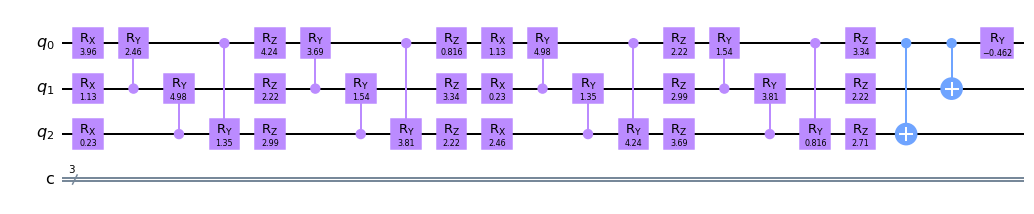

In [6]:
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
qc = qtm.qtm_nqubit.create_GHZchecker_binho(qc, thetas, num_layers, theta)
qc.draw('mpl')

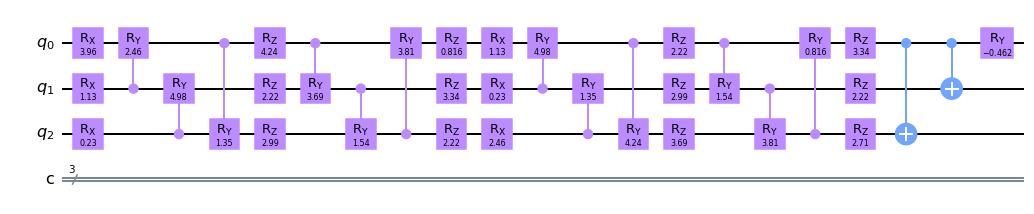

In [7]:
qc = qiskit.QuantumCircuit(num_qubits, num_qubits)
qc = qtm.qtm_nqubit.create_GHZchecker_koczor(qc, thetas, num_layers, theta)
qc.draw('mpl')